# ACM Image Classifier

# 1. Test Code to check installation of tensorflow

In [63]:
import tensorflow.compat.v1 as tf1
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

tf1.disable_v2_behavior()


In [44]:
 with tf1.Session() as ses:

     # Build a graph.
     b = tf.constant([1,2,3,4])
     a = tf.constant([5,6,7,8])
     d = tf.concat(a ,100)
     c = a * b

     # Evaluate the tensor `c`.
     print(ses.run(d))
     print(ses.run(c))

[5 6 7]
[ 5 12 32]


In [45]:
 with tf1.Session() as ses:

     # Build a graph.
     
     
     d = tf.random.uniform([1000,20000],0,1)
     e = tf.random.uniform([1000,20000],0,7)
     # Evaluate the tensor `c`.
     c = d*e
     #print(ses.run(e))
     print(ses.run(c))

[[1.8356345  0.1677035  5.964585   ... 0.19364221 1.0942171  3.0981884 ]
 [0.09862313 3.7217991  1.2237668  ... 0.17436002 1.029364   0.20907243]
 [1.8318801  0.73239815 0.14184146 ... 0.71591944 1.692384   0.215665  ]
 ...
 [1.2499211  0.7376043  1.6499598  ... 0.47356522 0.07113019 1.9038589 ]
 [0.01271696 0.6774325  2.4383607  ... 4.525194   3.132105   2.0728633 ]
 [0.64920354 1.3448879  4.3649774  ... 2.8003895  0.36924618 2.127932  ]]


# Test code for CIFAR-10 as taken from a website

In [46]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt


cifar10_dataset_folder_path = 'cifar-10-batches-py'

## This is pre-processing of data

In [47]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [48]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [49]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 999:
Image - Min Value: 1 Max Value: 238
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


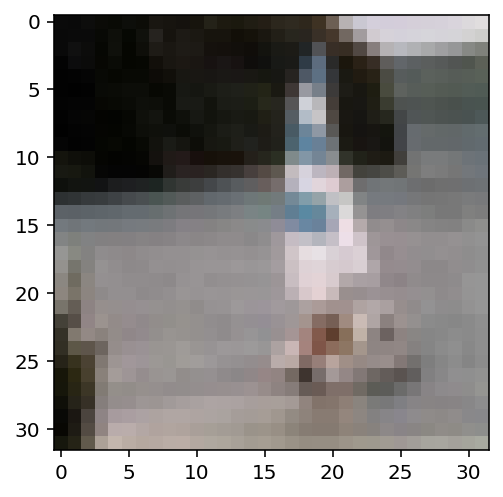

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 999
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [51]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [52]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded


In [53]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

In [54]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')


In [14]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


In [55]:


import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))



## Starting of Tensor-flow model :

In [56]:
# Remove previous weights, bias, inputs, etc..
from tensorflow.python.framework import ops
ops.reset_default_graph()
# Inputs
x =  tf1.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf1.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf1.placeholder(tf.float32, name='keep_prob')

# # Below one cell is function to implement fully connecetd layers (step 10-14)

In [64]:
#from keras.layers import Dropout

def fully_connected_layer():
    
    keep_prob=.2
    model=tf.keras.Sequential()
    
    #10
    model.add(layers.Dense(128,use_bias=True,input_shape=(2048,)))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    #model.add(Dropout(keep_prob))
    
    #11
    model.add(layers.Dense(256,use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    #model.add(Dropout(keep_prob))
    
    #12
    model.add(layers.Dense(512,use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    #model.add(Dropout(keep_prob))
    
    #13
    model.add(layers.Dense(1024,use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    #model.add(Dropout(keep_prob))
    
    #14
    model.add(layers.Dense(10,use_bias=True))
    
    
    return model

In [74]:

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf1.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf1.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf1.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf1.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    print(conv1)
    conv1 = tf.nn.relu(conv1)
    print(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    print(conv1_pool)
    conv1_bn = tf1.layers.batch_normalization(conv1_pool)
    print(conv1_bn)
    

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf1.layers.batch_normalization(conv2_pool)
    
    print(conv2)
    print(conv2_pool)
    print(conv2_bn)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf1.layers.batch_normalization(conv3_pool)
    
    print(conv3)
    print(conv3_pool)
    print(conv3_bn)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf1.layers.batch_normalization(conv4_pool)
    
    print(conv4)
    print(conv4_pool)
    print("NITK")
    print(conv4_bn)
    
    # 9 Flatten
    
    ############################### From here Done by abhi. Check if working fine.
    print(" After flattening: ")
    flat = tf.reshape(conv4_bn, [tf.shape(conv4_bn)[0], -1]) 
    #flat=tf.keras.backend.flatten(conv4_bn)
    print(flat)
    print(tf.size(flat))
    
    # 10
    
    #full1 = tf1.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    #full1 = tf.nn.dropout(full1, keep_prob)
    #full1 = tf1.layers.batch_normalization(full1)
    
    # 11
    #full2 = tf1.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    #full2 = tf.nn.dropout(full2, keep_prob)
    #full2 = tf1.layers.batch_normalization(full2)
    
    # 12
    #full3 = tf1.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    #full3 = tf.nn.dropout(full3, keep_prob)
    #full3 = tf1.layers.batch_normalization(full3)    
    
    # 13
    #full4 = tf1.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    #full4 = tf.nn.dropout(full4, keep_prob)
    #full4 = tf1.layers.batch_normalization(full4)        
    
    # 14
    #out = tf1.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    #return out
    
    #NEW 10-14
    print("Entered fully connected layer")
    generator = fully_connected_layer()
    final_output = generator(flat, training=False)
    print(final_output)
    return final_output

In [96]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [77]:

logits = conv_net(x, keep_prob)
print("logits=",logits)

Tensor("Conv2D_20:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("Relu_20:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("MaxPool_20:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("batch_normalization_36/FusedBatchNormV3:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("Relu_21:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("MaxPool_21:0", shape=(?, 8, 8, 128), dtype=float32)
Tensor("batch_normalization_37/FusedBatchNormV3:0", shape=(?, 8, 8, 128), dtype=float32)
Tensor("Relu_22:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("MaxPool_22:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("batch_normalization_38/FusedBatchNormV3:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("Relu_23:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("MaxPool_23:0", shape=(?, 2, 2, 512), dtype=float32)
NITK
Tensor("batch_normalization_39/FusedBatchNormV3:0", shape=(?, 2, 2, 512), dtype=float32)
 After flattening: 
Tensor("Reshape_5:0", shape=(?, ?), dtype=float32)
Tensor("Size_5:0", shape=(), dtype=

In [84]:
model1 = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [87]:
print(cost)
print(optimizer)
print(correct_pred)
print(accuracy)

Tensor("Mean_4:0", shape=(), dtype=float32)
name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable_20/ResourceApplyAdam"
input: "^Adam/update_Variable_21/ResourceApplyAdam"
input: "^Adam/update_Variable_22/ResourceApplyAdam"
input: "^Adam/update_Variable_23/ResourceApplyAdam"
input: "^Adam/update_batch_normalization_20/gamma/ApplyAdam"
input: "^Adam/update_batch_normalization_20/beta/ApplyAdam"
input: "^Adam/update_batch_normalization_21/gamma/ApplyAdam"
input: "^Adam/update_batch_normalization_21/beta/ApplyAdam"
input: "^Adam/update_batch_normalization_22/gamma/ApplyAdam"
input: "^Adam/update_batch_normalization_22/beta/ApplyAdam"
input: "^Adam/update_batch_normalization_23/gamma/ApplyAdam"
input: "^Adam/update_batch_normalization_23/beta/ApplyAdam"
input: "^Adam/update_dense_20/kernel/ResourceApplyAdam"
input: "^Adam/update_dense_20/bias/ResourceApplyAdam"
input: "^Adam/update_batch_normalization_40/gamma/ResourceApplyAdam"
input: "^Adam/update_batch_normalization_40/beta/ResourceAppl

In [88]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })



In [90]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

# # Fully training the model as shown in refernce link

In [92]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [97]:


save_model_path = './image_classification'

print('Training...')
with tf1.Session() as sess:
    # Initializing the variables
    sess.run(tf1.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)



Training...
Epoch  1, CIFAR-10 Batch 1:  

ResourceExhaustedError: OOM when allocating tensor with shape[5000,32,32,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Conv2D_20 (defined at /home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'Conv2D_20':
  File "/home/abhi/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/abhi/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/abhi/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/abhi/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/abhi/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-b4c3d0652d4b>", line 1, in <module>
    logits = conv_net(x, keep_prob)
  File "<ipython-input-74-1867c4d4dedf>", line 8, in conv_net
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_ops.py", line 1913, in conv2d_v2
    name=name)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_ops.py", line 2010, in conv2d
    name=name)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()
